https://deep-learning-study.tistory.com/534

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time
import copy

In [23]:
path='./data'

if not os.path.exists(path):
    os.mkdir(path)

train_ds=datasets.STL10(path, split='train', download=True, transform=transforms.ToTensor())
val_ds=datasets.STL10(path, split='test', download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [24]:
train_meanRGB=[np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB=[np.std(x.numpy(),axis=(1,2)) for x, _ in train_ds]

train_meanR=np.mean([m[0] for m in train_meanRGB])
train_meanG=np.mean([m[1] for m in train_meanRGB])
train_meanB=np.mean([m[2] for m in train_meanRGB])

train_stdR=np.mean([s[0] for s in train_stdRGB])
train_stdG=np.mean([s[1] for s in train_stdRGB])
train_stdB=np.mean([s[2] for s in train_stdRGB])

val_meanRGB=[np.mean(x.numpy(), axis=(1,2)) for x,_ in test_ds]
val_stdRGB=[np.std(x.numpy(), axis=(1,2)) for x,_ in test_ds]

val_meanR=np.mean([m[0] for m in val_meanRGB])
val_meanG=np.mean([m[1] for m in val_meanRGB])
val_meanB=np.mean([m[2] for m in val_meanRGB])

val_stdR=np.mean([s[0] for s in val_stdRGB])
val_stdG=np.mean([s[1] for s in val_stdRGB])
val_stdB=np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.4467106 0.43980986 0.40664646
8.073806e-06 7.5731277e-06 4.8856737e-06


In [25]:
train_transformation=transforms.Compose([transforms.ToTensor(), 
                                         transforms.Resize(224), 
                                         transforms.Normalize([train_meanR, train_meanG,train_meanB],
                                                              [train_stdR,train_stdG,train_stdB]),
                                        transforms.RandomHorizontalFlip()])
val_transformation=transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(224),
                                      transforms.Normalize([val_meanR, val_meanG, val_meanB],
                                                           [val_stdR, val_stdG, val_stdB])])

In [26]:
train_ds.transform=train_transformation
val_ds.transform=val_transformation

train_dl=DataLoader(train_ds, batch_size=32,shuffle=True)
val_dl=DataLoader(val_ds, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [ 235 3980  905 2763]
(3, 228, 906)
(228, 906, 3)


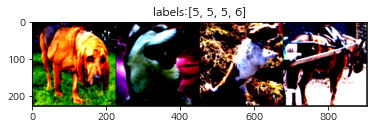

In [27]:
def show(img, y=None, color=True):
    npimg=img.numpy()
    print(npimg.shape)
    npimg_tr=np.transpose(npimg, (1,2,0))
    print(npimg_tr.shape)
    plt.imshow(npimg_tr)
    
    if y is not None:
        plt.title('labels:'+str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size=4
rnd_inds=np.random.randint(0, len(train_ds),grid_size)
print('image indices:', rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)

show(x_grid,y_grid)


In [28]:
class BasicBlock(nn.Module):
    expansion=1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function=nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=stride,padding=1,bias=False),
                                            nn.BatchNorm2d(out_channels),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels, out_channels * BasicBlock.expansion,
                                                      kernel_size=3,stride=stride,padding=1,bias=False),
                                            nn.BatchNorm2d(out_channels*BasicBlock.expansion))
        self.shortcut=nn.Sequential()
        self.relu=nn.ReLU()
        
        if stride!=1 or in_channels!=Basicblock.expansions*out_channels:
            self.shortcut=nn.Sequential(nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=stride,padding=1,bias=False),
                                       nn.BatchNorm2d(out_channels*BasicBlock.expansion))
    def forward(self, x):
        x.self=self.residual_function(x)+self.shortcut(x)
        x=self.relu(x)
        return x

In [29]:
class BottleNeck(nn.Module):
    expansion =4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=1,bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )
        
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()
        
        if stride !=1 or in_channels != out_channels *BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )
    
    def forward(self,x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [30]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10 ,init_weights=True):
        super().__init__()
        
        self.in_channels=64
        
        self.conv1=nn.Sequential(nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv2_x=self.make_layer(block, 64, num_block[0], 1)#이미 위에서 maxpooling 으로 잘림 stride=1
        self.conv3_x=self.make_layer(block, 128, num_block[1],2)# 이미지 사이즈 half됨.
        self.conv4_x=self.make_layer(block, 256, num_block[2],2)
        self.conv5_x=self.make_layer(block, 512, num_block[3],2)
        
        self.avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(512 * block.expansion, num_classes)
        
        if init_weights:
            self.initialize_weights()
        
        
    def make_layer(self, block, out_channels, num_blocks, stride):
        strides= [stride]+[1]*(num_blocks-1)
        layers=[]
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels=out_channels*block.expansion
            
        return nn.Sequential(*layers)
    
    def forward(self,x):
        output=self.conv1(x)
        output=self.conv2_x(output)
        x=self.conv3_x(output)
        x=self.conv4_x(x)
        x=self.conv5_x(x)
        x=self.avg_pool(x)
        x=x.view(x.size(0),-1)
        x=self.fc(x)
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight,0 ,0.01)
                nn.init.constant_(m.bias,0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3,4,6,3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3,4,23,3])

def resnet152():
    return ResNet(BottleNeck, [3,8,36,3])

In [31]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=resnet50().to(device)
x=torch.randn(3,3 ,224,224).to(device)
output=model(x)
print(output.size())

torch.Size([3, 10])


In [32]:
#손실함수
loss_func= nn.CrossEntropyLoss(reduction='sum')
opt=optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler=ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)
#patience: 학습률이 감소된후 개선되지 않는 epoch의수 default값은 10
#factor: 학습률이 감소되는 요소 새lr=facotr*기존lr

In [33]:
#현재의 lr를 얻어내는 함수
def get_lr(opt):
    for parm_group in opt.param_groups:
        return param_group['lr']

In [34]:
#metric per mini-batch 계산
def metric_batch(output, target):#batch에 대하여 주어진 척도에 얼마만큼 달성했는지 확인하는 metric_batch
    pred= output.argmax(1, keepdim=True)#출력 값은 (값,인덱스) index는 원-핫 인코딩으로 되어있음->라벨
    corrects= pred.eq(target.view_as(pred)).sum().item()#pred배열과 target.view_as(pred) 를 True,False로 반환
    return corrects

In [35]:
def loss_batch(loss_fn, output, target, opt=None):#one_batch에 대해서 loss를 구해주는 함수
    loss=loss_fn(output, target)
    metric_b= metric_batch(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item(), metric_b #손실이 갖고 있는 스칼라 값을 가져옴

In [36]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None ):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    
    for xb,yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        
        running_loss +=loss_b
        
        if metric_b is not None:
            running_metric +=metric_b
        
        if sanity_check is True:
            break
    
    loss=running_loss/len_data
    metric=running_metric/len_data
    
    return loss, metric

In [37]:
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=parama['loss_func']
    opt=param['optimizer']
    train_dl=params['train_dl']
    val_dl=parmas['val_dl']
    sanity_check=parmams['sanity check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']
    
    loss_history={'train':[],'val':[]}
    metric_history={'train':[],'val':[]}
    
    best_model_wts=copy.deepcopy(model.state_dict())
    
    best_loss=float('inf')
    start_time=time.time()
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current_lr={}'.format(epoch, num_epochs-1, current_lr))
        
        model.train()
        
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_histroy['train'].append(train_metric)
        
        model.eval()
        
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
            loss_history['val'].append(val_loss)
            metric_history['val'].append(val_metric)
            
        if val_loss<best_loss:
            best_loss=val_loss
            
            best_model_wts=copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')
            
            print('Get best val_loss')
            
        lr_scheduler.step(val_loss)
        
        print('train loss:.6f, val loss:.6f, accuracy: %.2f, time: %.4f min' 
              %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [39]:
param_train={
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weigths.pt'
}

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
        
createFolder('./model')

In [ ]:
model, loss_hist, metric_hist =train_val(model, param_train)